### Import dependencies

In [182]:
import pandas as pd
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colors import Normalize

import rasterio
import tifffile as tf

from netCDF4 import Dataset

import seaborn as sns
from scipy.integrate import solve_ivp 
from scipy.ndimage import zoom
from scipy import ndimage

import yaml

from PIL import Image

import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt


ModuleNotFoundError: No module named 'cartopy'

### Read in maps (now one time step, later timeseries)

In [185]:
#### set directories & load data ####

# Directory with input data
mapsDir = 'C:/FloodsAndHealthTool-main/examples/Data bronnen/'

# Load maps
flood = tf.imread(mapsDir+'flooded_zoom.tif')
popdens = tf.imread(mapsDir+'pop_dens_zoom.tif')
adults_pop = tf.imread(mapsDir+'adults_moz_masked.tif') 
children_pop = tf.imread(mapsDir+'kids_moz_masked.tif')

# remove no data values
flood[flood < -3.402822e+38] = np.nan
popdens[popdens < -3.402822e+38] = np.nan
adults_pop[adults_pop < -3.402822e+38] = np.nan
children_pop[children_pop < -3.402822e+38] = np.nan

# Convert the population arrays to a numeric data type
children_population_array = np.nan_to_num(children_pop).astype(float)
adults_population_array = np.nan_to_num(adults_pop).astype(float)

# Resize the array using NumPy's resize function
#resized_array_ch = np.resize(children_population_array, (150, 150))
#resized_array_ad = np.resize(adults_population_array, (150, 150))

# reshape_children = children_population_array.reshape(150, 150)

# Resize the array using interpolation
resized_array_ch = ndimage.zoom(children_population_array, (150 / children_population_array.shape[0], 150 / children_population_array.shape[1]), order=1)
resized_array_ad = ndimage.zoom(adults_population_array, (150 / adults_population_array.shape[0], 150 / adults_population_array.shape[1]), order=1) 
# Convert the resized array to an image using PIL's fromarray() function
resized_image_ch = Image.fromarray(resized_array_ch)

# Calculate the resize factor as the ratio of flood shape to children population shape
# resize_factor = (flood.shape[0] / children_population_array.shape[0],
#                  flood.shape[1] / children_population_array.shape[1])

# Resize the children population array to match the shape of the flood array
# resized_children_population = np.resize(children_population_array, flood.shape)
# resized_adults_population = np.resize(adults_population_array, flood.shape) 

# Save the resized population arrays as GeoTIFF files
# resized_children_pop = 'resized_children_population.tif'
# resized_adults_pop = 'resized_adults_population.tif'

#tf.imwrite(resized_children_pop, resized_children_population)
# tf.imwrite(resized_adults_pop, resized_adults_population)


In [ ]:
# User defined settings for pathogen and scenario selection

pathogen = 'E.coli' # select the pathogen for the simulation. Option at the moment is only 'E.coli'
source = 'Sewer_and_pluvial' #select the source of the pathogen. At the moment only 'Sewer_and_pluvial'
conc = 'max' #select the concentration of the pathogen: options are 'min' and 'max'
doseresp = 'poisson' #select the dose response curve of the pathogen for infection calculation. Either 'beta poisson' (keyword: 'poisson') or exponantial ('exp', not yet included)

#form values for poisson distribution
N50 = 896 #constant for the beta poisson infection risk calculation
NoE  = 4  #number of events per year 
alpha = 0.145 #form value for poisson distribution

In [ ]:
### I believe this one can be deletes....but maybe wait until the end of the week.

"""
with rasterio.open('pop_dens.tif') as src:
    window= rasterio.windows.Window(400, 525, 150, 150)
    subset = src.read(window=window)
    transform = src.window_transform(window)
    meta = src.meta.copy()
    meta.update({
        'height': window.height,
        'width': window.width,
        'transform': transform
    })

 
# Write the subset to a new file   
with rasterio.open('pop_dens_zoom.tif', 'w', **meta) as dst:
    dst.write(subset)

"""

"\nwith rasterio.open('pop_dens.tif') as src:\n    window= rasterio.windows.Window(400, 525, 150, 150)\n    subset = src.read(window=window)\n    transform = src.window_transform(window)\n    meta = src.meta.copy()\n    meta.update({\n        'height': window.height,\n        'width': window.width,\n        'transform': transform\n    })\n\n \n# Write the subset to a new file   \nwith rasterio.open('pop_dens_zoom.tif', 'w', **meta) as dst:\n    dst.write(subset)\n\n"

### Plot maps ###

Flooded area, population density in flooded area, adults & children in flooded area

C:\Users\bleser\AppData\Local\Temp\ipykernel_29620\3740392751.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)                                               # add colorbar


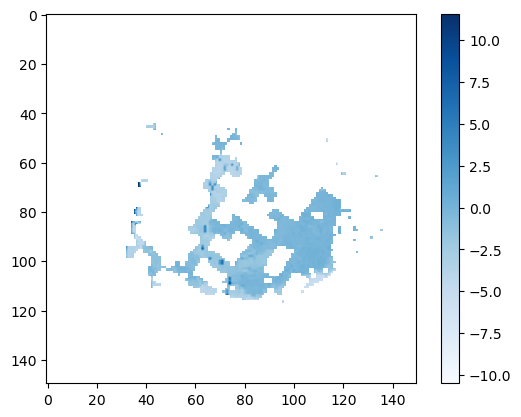

In [ ]:
### plot the flooding map ###

cmap = mpl.colormaps['Blues']                                               # set colormap
norm = plt.Normalize(vmin=np.nanmin(flood), vmax=np.nanmax(flood))          # set normalization
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)                          # create mappable

fig, ax = plt.subplots()                                                    # create figure and axes                                

im = ax.imshow(flood, cmap=cmap)                                          # create image                              
cbar = fig.colorbar(mappable)                                               # add colorbar                                              

plt.show()

C:\Users\bleser\AppData\Local\Temp\ipykernel_29620\1965335970.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)                                                # add colorbar


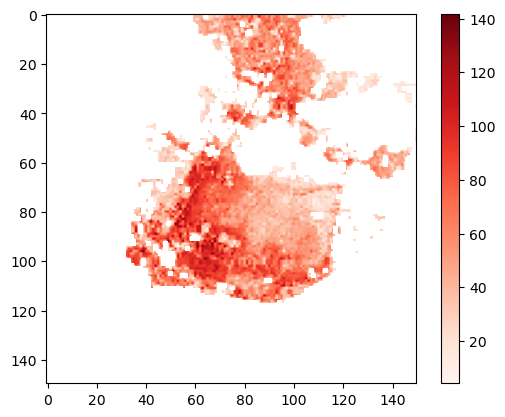

In [ ]:
#### Plot the population density map ####

cmap = mpl.colormaps['Reds']                                                 # set colormap              
norm = plt.Normalize(vmin=np.nanmin(popdens), vmax=np.nanmax(popdens))       # set normalization               
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)                           # create mappable                            

fig, ax = plt.subplots()                                                     # create figure and axes                           

im = ax.imshow(popdens, cmap=cmap)                                           # create image                               
cbar = fig.colorbar(mappable)                                                # add colorbar                     

plt.show()

### TODO solve MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. 
# Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
# cbar = fig.colorbar(mappable) 

C:\Users\bleser\AppData\Local\Temp\ipykernel_29620\1223197364.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)                                                # add colorbar


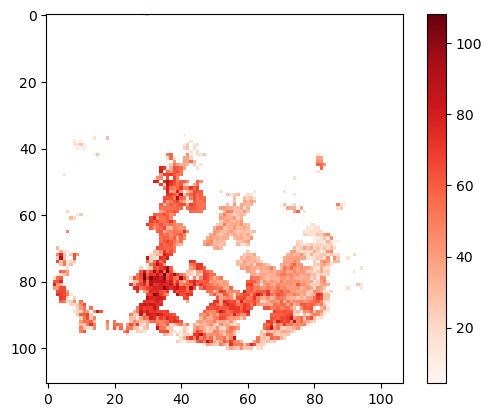

In [ ]:
#### Plot the population density map ADULTS #### --> Here is already a cutout of the flooded area

cmap = mpl.colormaps['Reds']                                                 # set colormap              
norm = plt.Normalize(vmin=np.nanmin(adults_pop), vmax=np.nanmax(adults_pop))       # set normalization               
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)                           # create mappable                            

fig, ax = plt.subplots()                                                     # create figure and axes                           

im = ax.imshow(adults_pop, cmap=cmap)                            # create image                               
cbar = fig.colorbar(mappable)                                                # add colorbar                     

plt.show()

C:\Users\bleser\AppData\Local\Temp\ipykernel_29620\2964149084.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)                                                # add colorbar


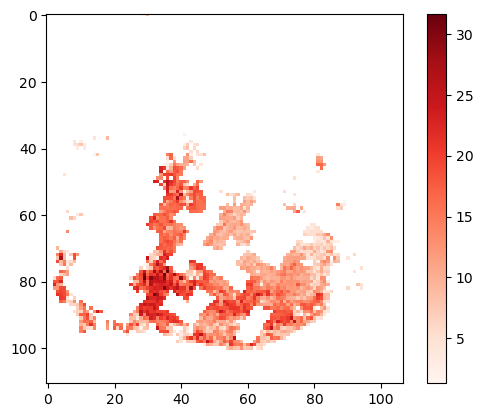

In [ ]:
#### Plot the population density map ChILDREN ### --> Here is already a cutout of the flooded area

cmap = mpl.colormaps['Reds']                                                 # set colormap              
norm = plt.Normalize(vmin=np.nanmin(children_pop), vmax=np.nanmax(children_pop))       # set normalization               
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)                           # create mappable                            

fig, ax = plt.subplots()                                                     # create figure and axes                           

im = ax.imshow(children_pop, cmap=cmap)                          # create image                               
cbar = fig.colorbar(mappable)                                                # add colorbar                     

plt.show()

### Resize Children and Adult population maps ?? Why does it look so weird? 

C:\Users\bleser\AppData\Local\Temp\ipykernel_29620\1317786943.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)                                                # add colorbar


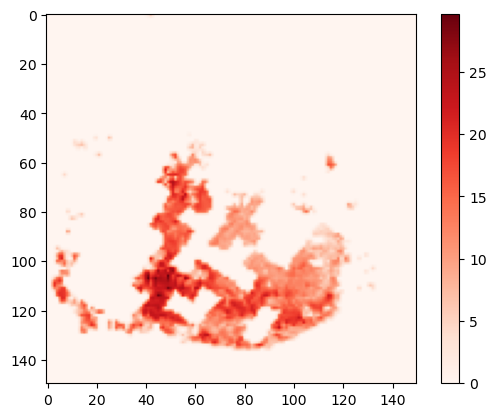

In [186]:
cmap = mpl.colormaps['Reds']                                                 # set colormap              
norm = plt.Normalize(vmin=np.nanmin(resized_array_ch), vmax=np.nanmax(resized_array_ch))       # set normalization               
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)                           # create mappable                            

fig, ax = plt.subplots()                                                     # create figure and axes                           

im = ax.imshow(resized_array_ch, cmap=cmap)                          # create image                               
cbar = fig.colorbar(mappable)                                                # add colorbar                     

plt.show()

In [ ]:
### Set the width of the classes

min_value = np.nanmin(popdens) # min values
max_value = np.nanmax(popdens) # max values
nr_of_classes = 5              # number of classes

int_width = (max_value-min_value)/nr_of_classes # interval width - there are other options for binning, this is just equal interval binning


In [ ]:
### Create the intervals

intervals = []                              # create empty list
for i in range(nr_of_classes):              # loop to create the class boundaries
    start = min_value + (i * int_width)     # lower boundary of the class
    end = start + int_width                 # upper boundary of the class
    intervals.append((start, end))          # append the tuple of the class boundaries to the list


In [ ]:
### Assign data points to intervals

groups = [[] for _ in range(nr_of_classes)]             # create empty list of lists

for row in popdens:                                     # loop over the rows                                            
    for value in row:                                   # loop over the values in the row    
        for i, (start, end) in enumerate(intervals):    # loop over the intervals (i is the index of the interval)
            if start <= value < end:                    # check if the value is in the interval
                groups[i].append(value)                 # if yes, append to the list of the interval
                break                                   # break the loop over the intervals when the value is found



In [ ]:
### Get the counts of the groups
group_counts = [len(group) for group in groups]

print(group_counts)

[2130, 2596, 1634, 643, 65]


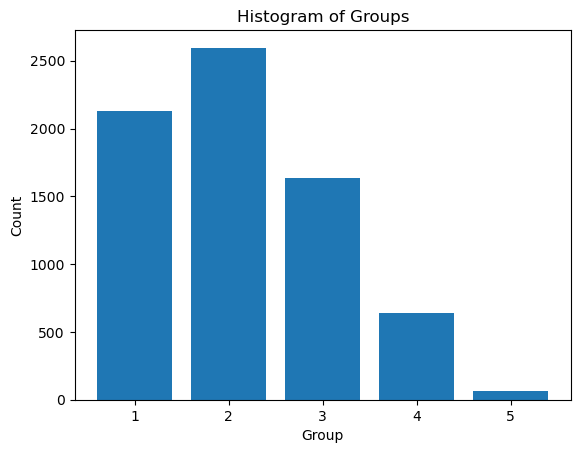

In [ ]:
### Plot the histogram

plt.bar(range(1, nr_of_classes+1), group_counts)    # plot the bars, nr_of_classes+1 because the range is exclusive
plt.xlabel('Group')                                 # set the labels                     
plt.ylabel('Count')                                                                     
plt.title('Histogram of Groups')                    # set the title                                

plt.show()

### Visualize & calculate affected population
In the part below, some overlays are made to link flooding to population density to get info how many people are affected by the flood & how they are affected. The latter has been expressed by linking water depth to 'behavior' like wading and swimming.

In [188]:
### create overlays to get dry and flooded areas ###
overl_flarea = np.where(flood >= np.nanmin(flood),popdens,np.nan)
overl_dryarea = np.where(np.isnan(flood),popdens,np.nan)
overl_flarea_adults = np.where(flood >= np.nanmin(flood),resized_array_ad,np.nan)
overl_dryarea_children = np.where(np.isnan(flood),resized_array_ch,np.nan)

C:\Users\bleser\AppData\Local\Temp\ipykernel_29620\3725738846.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


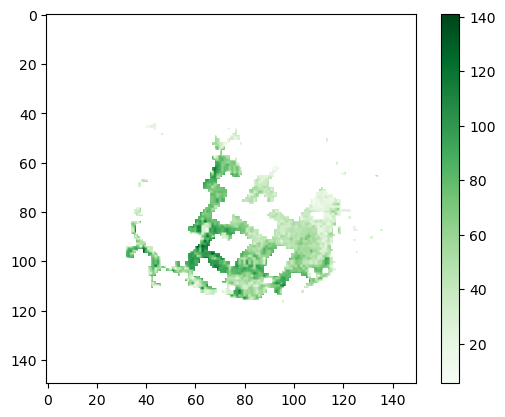

C:\Users\bleser\AppData\Local\Temp\ipykernel_29620\3725738846.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


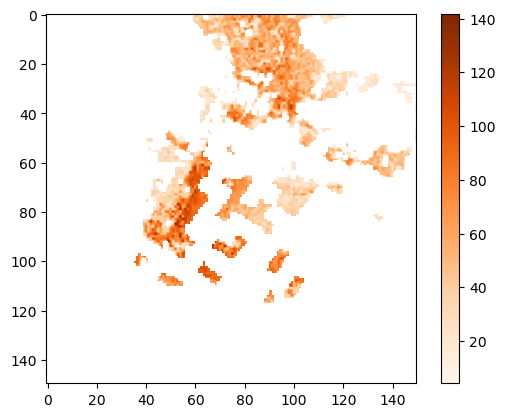

In [189]:
### plot the overlays ###

# plot the flooded area
cmap = mpl.colormaps['Greens']
norm = plt.Normalize(vmin=np.nanmin(overl_flarea), vmax=np.nanmax(overl_flarea))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
fig, ax = plt.subplots()

im = ax.imshow(overl_flarea, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

# plot the dry area
cmap = mpl.colormaps['Oranges']
norm = plt.Normalize(vmin=np.nanmin(overl_dryarea), vmax=np.nanmax(overl_dryarea))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
fig, ax = plt.subplots()

im = ax.imshow(overl_dryarea, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

In [198]:
### Give info on the population in the flooded and dry areas ###
print('total inhabitants in total area:', round(np.nansum(popdens),0))
print('total inhabitants in flooded area:', round(np.nansum(overl_flarea),0), '(', round((np.nansum(overl_flarea)/np.nansum(popdens))*100,0),'%)')
print('total inhabitants in dry area:', round(np.nansum(overl_dryarea),0), '(', round((np.nansum(overl_dryarea)/np.nansum(popdens))*100,0),'%)')
# why doesnt it work? print('total children in flooded area:', round(np.nansum (overl_flarea),0)), '(', round((np.nansum(overl_flarea)/np.nansum(children_population_array))*100,0),'%)'
# why doesnt it work? print('total adults in flooded area:', round(np.nansum (overl_flarea),0)), '(', round((np.nansum(overl_flarea)/np.nansum(adults_pop))*100,0),'%)'


total inhabitants in total area: 347166.0
total inhabitants in flooded area: 137904.0 ( 40.0 %)
total inhabitants in dry area: 209261.0 ( 60.0 %)


In [ ]:
### Create claases for the flooded area ###

wclass = flood.copy()                                    # create a copy of the flood map
wclass[wclass>0]=np.nan                                  # filter the dry land out        
wclass[np.logical_and(wclass<0,wclass>=-0.1)]= 1         # assign the classes
wclass[np.logical_and(wclass<-0.1,wclass>=-0.5)]=2                                  
wclass[np.logical_and(wclass<-0.5,wclass>=-1.5)]=3
wclass[wclass<-1.5]= 4

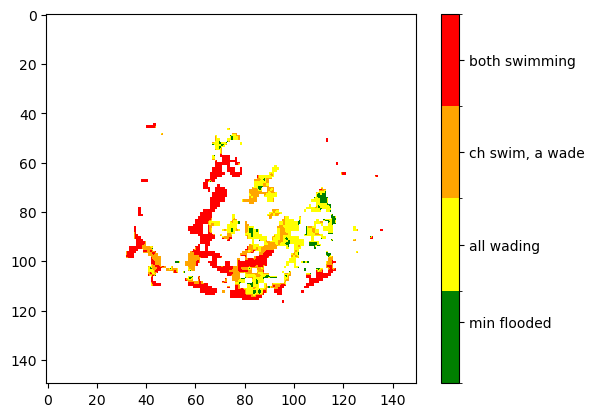

In [ ]:
### Plot the classes ###

cmap = ListedColormap(['green', 'yellow', 'orange', 'red'])
bounds = [0, 1.5, 2.5, 3.5, 4.5]
norm = BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()

im = ax.imshow(wclass, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ticks=[1,2, 3,4], boundaries=bounds)
cbar.ax.set_yticklabels(['min flooded', 'all wading', 'ch swim, a wade', 'both swimming'])
plt.show()

In [207]:
### Give info on the population in the flooded area and distinct between childs and adults ###

# make distinction between adults&children

ch_pop_class1 = round(np.nansum(resized_array_ch[wclass==1]),0) 
ch_pop_class2 = round(np.nansum(resized_array_ch[wclass==2]),0)
ch_pop_class3 = round(np.nansum(resized_array_ch[wclass==3]),0)
ch_pop_class4 = round(np.nansum(resized_array_ch[wclass==4]),0)

print('total children in flooded area:', round(np.nansum(resized_array_ch),0))
print('total children in minimum flooded area:', ch_pop_class1)
print('total children in area where everyone is wading:', ch_pop_class2)
print('total children in area where children swim and adults wade:', ch_pop_class3)
print('total children in area where everyone is swimming:', ch_pop_class4)

ad_pop_class1 = round(np.nansum(resized_adults_population[wclass==1]),0)
ad_pop_class2 = round(np.nansum(resized_adults_population[wclass==2]),0)
ad_pop_class3 = round(np.nansum(resized_adults_population[wclass==3]),0)
ad_pop_class4 = round(np.nansum(resized_adults_population[wclass==4]),0)

print('total adults in flooded area:', round(np.nansum(resized_array_ad),0))    
print('total adults in minimum flooded area:', ad_pop_class1)
print('total adults in area where everyone is wading:', ad_pop_class2)
print('total adults in area where children swim and adults wade:', ad_pop_class3)
print('total adults in area where everyone is swimming:', ad_pop_class4)

# together with population data you know how many in each class, which can be highlighted in maps
print('total inhabitants in minimum flooded area:', round(np.nansum(wclass[wclass==1]),0),'(',round((np.nansum(wclass[wclass==1])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where everyone is wading:', round(np.nansum(wclass[wclass==2]),0),'(',round((np.nansum(wclass[wclass==2])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where children swim and adults wade:', round(np.nansum(wclass[wclass==3]),0),'(',round((np.nansum(wclass[wclass==3])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where everyone is swimming:', round(np.nansum(wclass[wclass==4]),0),'(',round((np.nansum(wclass[wclass==4])/np.nansum(wclass))*100,0),'%)')

# exposure data should be read in from text file
# read in dose response relations (via text file - link to different modules)

total children in flooded area: 45427.0
total children in minimum flooded area: 0.0
total children in area where everyone is wading: 2490.0
total children in area where children swim and adults wade: 2221.0
total children in area where everyone is swimming: 4758.0
total adults in flooded area: 155187.0
total adults in minimum flooded area: 0.0
total adults in area where everyone is wading: 1930.0
total adults in area where children swim and adults wade: 670.0
total adults in area where everyone is swimming: 4875.0
total inhabitants in minimum flooded area: 0.0 ( 0.0 %)
total inhabitants in area where everyone is wading: 1416.0 ( 22.0 %)
total inhabitants in area where children swim and adults wade: 1494.0 ( 23.0 %)
total inhabitants in area where everyone is swimming: 3648.0 ( 56.0 %)


### Import pathogen concentration with YAML file

In [ ]:
# Read YAML file
with open('Scenarios_Pathogen.yml', 'r') as file:
    data = yaml.safe_load(file)

pathogen_name = 'E.coli'
source_name = 'Sewer_and_pluvial'
conc_type = 'min'

# Find the pathogen
selected_pathogen = None
for pathogen in data['pathogens']:
    if pathogen['name'] == pathogen_name:
        selected_pathogen = pathogen
        break

if selected_pathogen:
    print('Selected pathogen:', selected_pathogen['name'])

    # Find the scenario for the given source
    selected_scenario = None
    for scenario in selected_pathogen['scenarios']:
        if scenario['source'] == source_name:
            selected_scenario = scenario
            break

    if selected_scenario:
        print('Used source:', selected_scenario['source'])
        print('Used unit:', selected_scenario['units'])

        # Retrieve the concentration based on the conc_type
        if conc_type == 'min':
            concentration = selected_scenario['min_conc']
            print('Using minimum concentration:', concentration)
        elif conc_type == 'max':
            concentration = selected_scenario['max_conc']
            print('Using maximum concentration:', concentration)
        else:
            print('Invalid concentration type')
    else:
        print('No scenario found for the specified source')
else:
    print('No pathogen found with the specified name')

PatConc = float(concentration)
print(PatConc)



Selected pathogen: E.coli
Used source: Sewer_and_pluvial
Used unit: MPN/ml
Using minimum concentration: 1000
1000.0


### Read in exposure data with YAML file and calculate ingested Dose 

In [ ]:
# Read exposure data from YAML file
with open("Exposure_scenarios.yml", "r") as file:
    exposure_data = yaml.safe_load(file)

# Retrieve concentration and unit for specific exposure scenarios
ad_sp = exposure_data["-Splashed_Adult"]["conc"]
ad_sw = exposure_data["-Swimming_Adult"]["conc"]
ch_pl = exposure_data["-Playing_Children"]["conc"]
ch_sw = exposure_data["-Swimming_Children"]["conc"]

unit_ad_sp = exposure_data["-Splashed_Adult"]["unit"]
unit_ad_sw = exposure_data["-Swimming_Adult"]["unit"]
unit_ch_pl = exposure_data["-Playing_Children"]["unit"]
unit_ch_sw = exposure_data["-Swimming_Children"]["unit"]

# Print the concentration and unit for the specific exposure scenarios
print("Splashed_Adult:")
print("  Concentration:", ad_sp)
print("  Unit:", unit_ad_sp)
print()

print("Swimming_Adult:")
print("  Concentration:", ad_sw)
print("  Unit:", unit_ad_sw)
print()

print("Playing_Children:")
print("  Concentration:", ch_pl)
print("  Unit:", unit_ch_pl)
print()

print("Swimming_Children:")
print("  Concentration:", ch_sw)
print("  Unit:", unit_ch_sw)
print()

# Perform dose calculations
dAd_sp = (PatConc / 1000) * ad_sp
dAd_sw = (PatConc/ 1000) * ad_sw
dCh_pl = (PatConc / 1000) * ch_pl
dCh_sw = (PatConc / 1000) * ch_sw

# Print the results
print(dAd_sp)
print(dAd_sw)
print(dCh_pl)
print(dCh_sw)

Splashed_Adult:
  Concentration: 10
  Unit: ml/event

Swimming_Adult:
  Concentration: 3.5
  Unit: ml/h

Playing_Children:
  Concentration: 30
  Unit: ml/d

Swimming_Children:
  Concentration: 50
  Unit: ml/h

10.0
3.5
30.0
50.0


### DOSE - Relate pathogen concentration to exposure levels
In this part, four flooding water depths are assumed: 0-0.10 (value 1), 0.1-0.5 (value 2),0.5-1.5 (value 3)and >1.5 (value 4). It is assumed that value 1 has no additional expore to not flooded, value 2 relates to wading of both children and adults, value 3 to swimming of children and wading by adults and value 4 both children and adults swim 


In [ ]:
# display ingestede dose for children and adults on map
wclass[wclass==1]=np.nan
dose_ad = wclass.copy()
dose_ad[np.logical_or(dose_ad==2,dose_ad==3)] = dAd_sp
dose_ad[dose_ad==4] = dAd_sw

dose_ch = wclass.copy()
dose_ch[dose_ch==2] = dCh_pl
dose_ch[np.logical_or(dose_ch==3,dose_ch==4)] = dCh_sw



C:\Users\bleser\AppData\Local\Temp\ipykernel_29620\1365893742.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


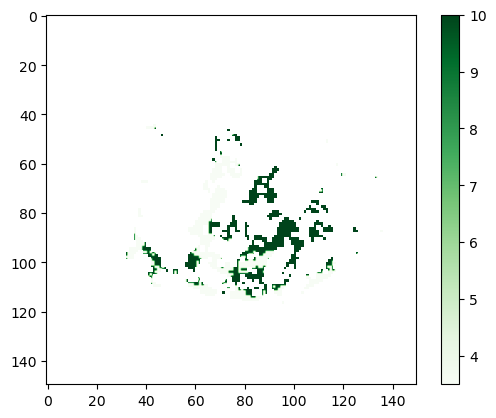

C:\Users\bleser\AppData\Local\Temp\ipykernel_29620\1365893742.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


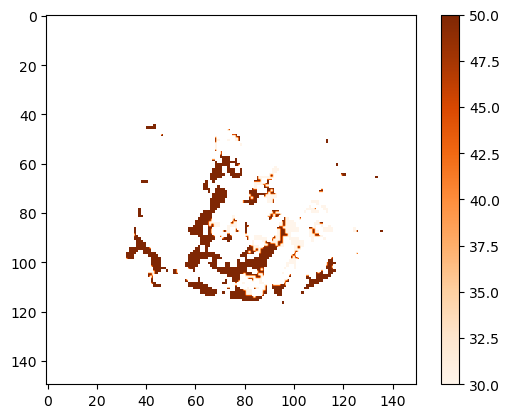

In [ ]:
cmap = mpl.colormaps['Greens']
norm = plt.Normalize(vmin=np.nanmin(dose_ad), vmax=np.nanmax(dose_ad))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()

im = ax.imshow(dose_ad, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

cmap = mpl.colormaps['Oranges']
norm = plt.Normalize(vmin=np.nanmin(dose_ch), vmax=np.nanmax(dose_ch))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()

im = ax.imshow(dose_ch, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

### Calculate and map out infection Risk per exposure group

In [217]:
InfRisk_Ad_sp = 1 - (1+(dAd_sp/N50)*(2**(1/alpha)-1))**-alpha
InfRisk_Ad_sw = 1 - (1+(dAd_sw/N50)*(2**(1/alpha)-1))**-alpha

InfRisk_Ch_pl = 1 - (1+(dCh_pl/N50)*(2**(1/alpha)-1))**-alpha
InfRisk_Ch_sw = 1 - (1+(dCh_sw/N50)*(2**(1/alpha)-1))**-alpha

print(InfRisk_Ad_sp)
print(InfRisk_Ad_sw)
print(InfRisk_Ch_pl)
print(InfRisk_Ch_sw)



0.1147961381595558
0.053535518074158794
0.20711542215916856
0.2546819255059928
Total adults at risk in area where everyone is wading 0.0
Total adults at risk where everyone is wading 22155.65466479427
Total adults at risk where children are swimming and adults are wading 3586.879710968639
Total adults at risk where everyone is swimming 26098.565061152414
Total children at risk in area where everyone is wading 0.0
Total children at risk where everyone is wading 51571.74011763297
Total children at risk where children are swimming and adults are wading 56564.855654881
Total children at risk where everyone is swimming 121177.66015575136


In [ ]:
# display infection risk on map
inf_ad = wclass.copy()
inf_ad[np.logical_or(inf_ad==2,inf_ad==3)] = InfRisk_Ad_sp
inf_ad[inf_ad==4] = InfRisk_Ad_sw

inf_ch = wclass.copy()
inf_ch[inf_ch==2] =InfRisk_Ch_pl
inf_ch[np.logical_or(inf_ch==3,inf_ch==4)] = InfRisk_Ch_sw


C:\Users\bleser\AppData\Local\Temp\ipykernel_29620\3706364919.py:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


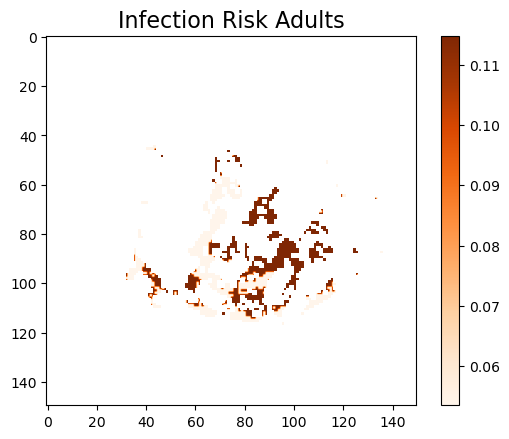

C:\Users\bleser\AppData\Local\Temp\ipykernel_29620\3706364919.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


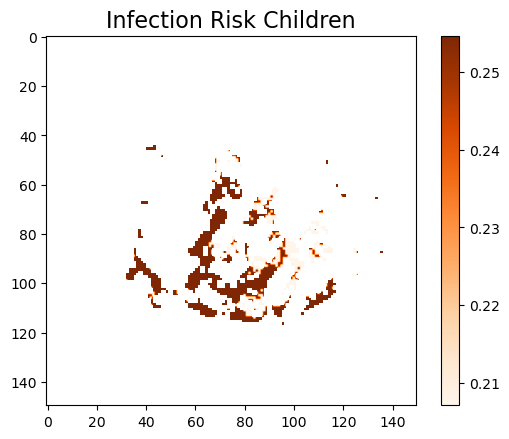

In [ ]:
# Map infection risk adults
cmap = mpl.colormaps['Oranges']
norm = plt.Normalize(vmin=np.nanmin(inf_ad), vmax=np.nanmax(inf_ad))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()
plt.title('Infection Risk Adults', fontsize=16, color='black')
im = ax.imshow(inf_ad, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

#Map infection risk children 
cmap = mpl.colormaps['Oranges']
norm = plt.Normalize(vmin=np.nanmin(inf_ch), vmax=np.nanmax(inf_ch))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()
plt.title('Infection Risk Children', fontsize=16, color='black')
im = ax.imshow(inf_ch, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()


In [218]:
#Population counts per infection risk class
Total_risk_ad_1 = ad_pop_class1 * InfRisk_Ad_sp * 100
Total_risk_ad_2 = ad_pop_class2 * InfRisk_Ad_sp * 100
Total_risk_ad_3 = ad_pop_class3 * InfRisk_Ad_sw * 100
Total_risk_ad_4 = ad_pop_class4 * InfRisk_Ad_sw * 100

Total_risk_ch_1 = ch_pop_class1 * InfRisk_Ch_pl * 100
Total_risk_ch_2 = ch_pop_class2 * InfRisk_Ch_pl * 100
Total_risk_ch_3 = ch_pop_class3 * InfRisk_Ch_sw * 100
Total_risk_ch_4 = ch_pop_class4 * InfRisk_Ch_sw * 100

print('Total adults at risk in area where everyone is wading', Total_risk_ad_1)
print('Total adults at risk where everyone is wading', Total_risk_ad_2)
print('Total adults at risk where children are swimming and adults are wading', Total_risk_ad_3)
print('Total adults at risk where everyone is swimming', Total_risk_ad_4)

print('Total children at risk in area where everyone is wading', Total_risk_ch_1)
print('Total children at risk where everyone is wading', Total_risk_ch_2)
print('Total children at risk where children are swimming and adults are wading', Total_risk_ch_3)
print('Total children at risk where everyone is swimming', Total_risk_ch_4)

Total adults at risk in area where everyone is wading 0.0
Total adults at risk where everyone is wading 22155.65466479427
Total adults at risk where children are swimming and adults are wading 3586.879710968639
Total adults at risk where everyone is swimming 26098.565061152414
Total children at risk in area where everyone is wading 0.0
Total children at risk where everyone is wading 51571.74011763297
Total children at risk where children are swimming and adults are wading 56564.855654881
Total children at risk where everyone is swimming 121177.66015575136


In [234]:
#Combine infection risk map with children population
inf_ch[inf_ch==0] = np.nan
inf_ch[inf_ch==1] = np.nan
inf_ch[inf_ch==2] = np.nan
inf_ch[inf_ch==3] = np.nan
inf_ch[inf_ch==4] = np.nan

inf_ch[inf_ch==np.nan] = 0

inf_ch_total = inf_ch * resized_array_ch

print (inf_ch_total)

#Combine infection risk map with adult population
inf_ad[inf_ad==0] = np.nan
inf_ad[inf_ad==1] = np.nan
inf_ad[inf_ad==2] = np.nan
inf_ad[inf_ad==3] = np.nan
inf_ad[inf_ad==4] = np.nan

inf_ad[inf_ad==np.nan] = 0

inf_ad_total = inf_ad * resized_array_ad

print (inf_ad_total)



[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


### Population count adults and children - Can be deleted

c:\Users\bleser\.conda\envs\floodshealth\lib\site-packages\matplotlib\colors.py:719: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


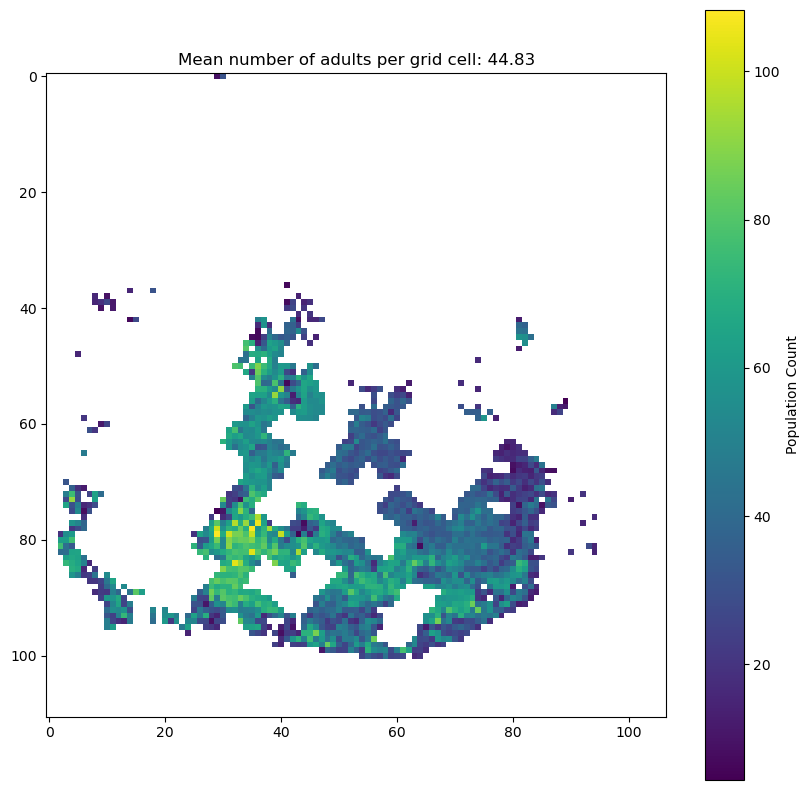

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Load the adult TIFF file
adults_pop_path = r'C:\FloodsAndHealthTool-main\examples\Data bronnen\adults_moz_masked.tif'

with rasterio.open(adults_pop_path) as adults_ds:
    adults_population = adults_ds.read(1, masked=True).astype(np.float32)

    # Calculate the mean number per grid cell
    mean_number = np.nanmean(adults_population)

    # Create a color-coded map of the mean number
    fig, ax = plt.subplots(figsize=(10, 10))
    cmap = plt.cm.viridis

    # Plot the population map with color intensity representing the mean number
    im = ax.imshow(adults_population, cmap=cmap)

    # Add a colorbar
    cbar = plt.colorbar(im, ax=ax, label='Population Count')

    # Set the title and display the mean number
    title = 'Mean number of adults per grid cell: {:.2f}'.format(mean_number)
    plt.title(title)

    # Display the map
    plt.show()

c:\Users\bleser\.conda\envs\floodshealth\lib\site-packages\matplotlib\colors.py:719: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


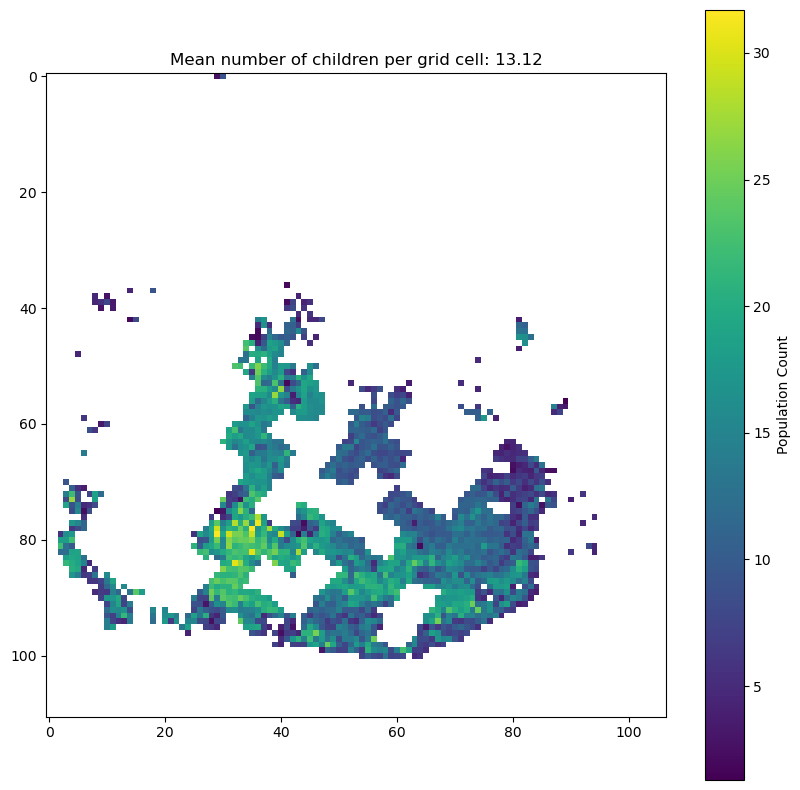

In [ ]:
# Load the children TIFF file
children_pop_path = r'C:\FloodsAndHealthTool-main\examples\Data bronnen\kids_moz_masked.tif'

with rasterio.open(children_pop_path) as children_ds:
    children_population = children_ds.read(1, masked=True).astype(np.float32)

    # Calculate the mean number per grid cell
    mean_number = np.nanmean(children_population)

    # Create a color-coded map of the mean number
    fig, ax = plt.subplots(figsize=(10, 10))
    cmap = plt.cm.viridis

    # Plot the population map with color intensity representing the mean number
    im = ax.imshow(children_population, cmap=cmap)

    # Add a colorbar
    cbar = plt.colorbar(im, ax=ax, label='Population Count')

    # Set the title and display the mean number
    title = 'Mean number of children per grid cell: {:.2f}'.format(mean_number)
    plt.title(title)

    # Display the map
    plt.show()

In [ ]:
# Set the print options to display the full array without scientific notation
np.set_printoptions(suppress=True, precision=2)

# Print the adult and children population arrays
print("Adults Population:")
print(adults_population)

print("Children Population:")
print(children_population)

Adults Population:
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]
Children Population:
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]


### Combine infection risk and population counts/adults/children

In [ ]:
#Estimate number of infections with infection risk for each exposure group per grid cell

#Multiply population in age groups with infection risk for each exposure group per grid cell
print(InfRisk_Ad_sp)
print(InfRisk_Ad_sw)
print(InfRisk_Ch_pl)
print(InfRisk_Ch_sw)

# Multiply population in age groups with infection risk for each exposure group per grid cell
Inf_Ad_sp = InfRisk_Ad_sp * adults_population
Inf_Ad_sw = InfRisk_Ad_sw * adults_population
Inf_Ch_pl = InfRisk_Ch_pl * children_population
Inf_Ch_sw = InfRisk_Ch_sw * children_population

print(Inf_Ad_sp)
print(Inf_Ad_sw)
print(Inf_Ch_pl)
print(Inf_Ch_sw)

#multiply each grid cell with the infection risk

print('total inhabitants in minimum flooded area:', round(np.nansum(wclass[wclass==1]),0),'(',round((np.nansum(wclass[wclass==1])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where everyone is wading:', round(np.nansum(wclass[wclass==2]),0),'(',round((np.nansum(wclass[wclass==2])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where children swim and adults wade:', round(np.nansum(wclass[wclass==3]),0),'(',round((np.nansum(wclass[wclass==3])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where everyone is swimming:', round(np.nansum(wclass[wclass==4]),0),'(',round((np.nansum(wclass[wclass==4])/np.nansum(wclass))*100,0),'%)')

flooded_population_total = round(np.nansum(overl_flarea),0)
#flooded_children_sw =
#flooded_children_pl = 
#flooded_adults_wa = 
#flooded_adults_sw =  

print('Total Flooded Population:', flooded_population_total)
#print(flooded_children_pl)
#print(flooded_children_sw)
#print (flooded_adults_wa)
#print (flooded_adults_sw)

Infected_population = flooded_population_total * InfRisk_Ch_sw #max scenario for whole population, later distinction between vulnerability groups

print(Infected_population)

### Histogram Risk classes ###


In [ ]:
### Set the width of the classes

min_value = np.nanmin(resized_array_ch) # min values
max_value = np.nanmax(resized_array_ch) # max values
nr_of_classes = 5              # number of classes

int_width = (max_value-min_value)/nr_of_classes # interval width - there are other options for binning, this is just equal interval binning


In [ ]:
### Create the intervals

intervals = []                              # create empty list
for i in range(nr_of_classes):              # loop to create the class boundaries
    start = min_value + (i * int_width)     # lower boundary of the class
    end = start + int_width                 # upper boundary of the class
    intervals.append((start, end))          # append the tuple of the class boundaries to the list


In [ ]:
### Assign data points to intervals

groups = [[] for _ in range(nr_of_classes)]             # create empty list of lists

for row in resized_array_ch:                                     # loop over the rows                                            
    for value in row:                                   # loop over the values in the row    
        for i, (start, end) in enumerate(intervals):    # loop over the intervals (i is the index of the interval)
            if start <= value < end:                    # check if the value is in the interval
                groups[i].append(value)                 # if yes, append to the list of the interval
                break                                   # break the loop over the intervals when the value is found



In [ ]:
### Get the counts of the groups
group_counts = [len(group) for group in groups]

print(group_counts)

[2130, 2596, 1634, 643, 65]


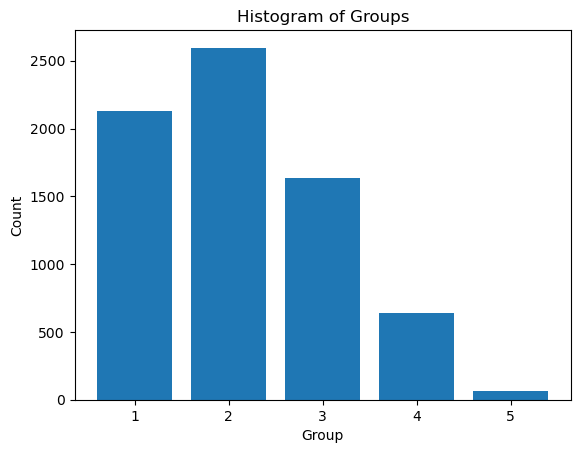

In [ ]:
### Plot the histogram

plt.bar(range(1, nr_of_classes+1), group_counts)    # plot the bars, nr_of_classes+1 because the range is exclusive
plt.xlabel('Group')                                 # set the labels                     
plt.ylabel('Count')                                                                     
plt.title('Histogram of Groups')                    # set the title                                

plt.show()

In [230]:

# Perform the multiplication
Inf_children_total = np.nansum(inf_ch * resized_array_ch)
Inf_adults_total = np.nansum(inf_ad * resized_array_ad)

# Print the results
print(Inf_children_total)
print(Inf_adults_total)

2293.2350588342024
2717.9047203835503


### Histogramm code ###

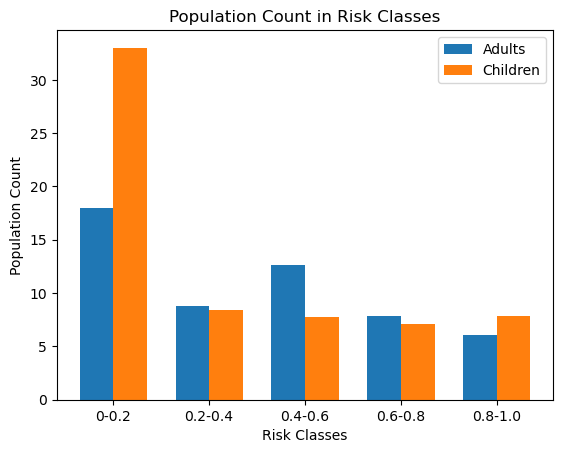

In [236]:


# Replace NaN values with 0
adults_population = np.nan_to_num(resized_array_ad, nan=0)
children_population = np.nan_to_num(resized_array_ch, nan=0)

# Calculate the number of adults and children in each risk class
risk_classes = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
adults_count = np.zeros(len(risk_classes) - 1, dtype=float)
children_count = np.zeros(len(risk_classes) - 1, dtype=float)

for i in range(len(risk_classes) - 1):
    adults_mask = (inf_ad >= risk_classes[i]) & (inf_ad < risk_classes[i + 1])
    children_mask = (inf_ch >= risk_classes[i]) & (inf_ch < risk_classes[i + 1])

    adults_count[i] = np.sum(adults_mask * adults_population)
    children_count[i] = np.sum(children_mask * children_population)

# Plot histograms for adults and children
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(risk_classes) - 1)

ax.bar(index, adults_count, bar_width, label='Adults')
ax.bar(index + bar_width, children_count, bar_width, label='Children')

ax.set_xlabel('Risk Classes')
ax.set_ylabel('Population Count')
ax.set_title('Population Count in Risk Classes')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f'{risk_classes[i]}-{risk_classes[i + 1]}' for i in range(len(risk_classes) - 1)])
ax.legend()

plt.show()

### SIR MODEL (now cholera)

In [ ]:
#SIR model for V. cholera

# Parameters
b = 0.000072  # natural birth rates of humans per time, fixed value
betaB = 0.5  # ingestion rate of vibrio from environment, ranges between 0.001-0.5 for cholera
betaI = 0.2  # person to person infectivity, ranges between 0.001-0.5 for cholera
d = 0.000044  # natural death rates of humans per time, fixed value
delta = 0.05  # death rate of vibrios from HI to non-HI state, ranges between 0.025 - 0.33 for cholera
eta = 0.500  # rate of infected contribution to environmental vibrio concentration, ranges between 0.0001-10 for cholera
p_gamma = 0.08  # cholera recovery rate for infecteds, ranges between 1/14 - 1/7 for cholera. Used p_ to make a distinction between inbuild function and this parameter
p_kappa = 10E6 # half saturation constant of vibrio, fixed value. Used p_ to make a distinction between inbuild function and this parameter
omega = 0.0015  # rate of waning immunity from R to S, ranges between 0.00001-1/190 for cholera


# State variables
S = np.array([flooded_population_total]) # number of susceptible humans
I = np.array([Infected_population])  # number of infected humans
R = np.array([0.0])  # number of recovered humans ##changed from 1 to 0
N = np.array([S + I + R])  # total population in all human compartments #
B = np.array([10.0])  # concentration of vibrios in environment, unit so far unknown

# Parameters and state variables as a list
parameters = [b, betaB, betaI, d, delta, eta, p_gamma, p_kappa, omega]
states = [S, I, R, N, B]

# Define time
times = np.arange(0, 301, 301)  # in days or whatever timestep is suitable

# ODE function
def proc_ode(t, y, parameters):
    S, I, R, N, B = y
    b, betaB, betaI, d, delta, eta, p_gamma, p_kappa, omega = parameters

    dS = b * N - d * S - betaB * (B * S / (p_kappa + B)) - betaI * (S * I / N) + omega * R
    dI = -d * I + betaB * (B * S / (p_kappa + B)) + betaI * (S * I / N) - p_gamma *  I 
    dR = -d * R + p_gamma * I - omega * R
    dB = eta * I - delta * B
    dN = dS + dI + dR

    return [dS, dI, dR, dN, dB] #N and B are constants, no derivates

# Solve the ODEs
times = np.linspace(0, 300, 301)
initial_conditions = np.ravel(states) #convert to list and make y0 one-dimensional with np.ravel
solution = solve_ivp(proc_ode, [times[0], times[-1]], initial_conditions, t_eval=times, args=(parameters,))

# Convert the solution to a DataFrame
df_solution = pd.DataFrame(solution.y.T, columns=['S', 'I', 'R', 'N', 'B'])

# Plotting
sns.set_style('darkgrid')
plt.plot(times, df_solution['S'], label='Susceptible')
plt.plot(times, df_solution['I'], label='Infected')
plt.plot(times, df_solution['R'], label='Recovered')
plt.plot(times, df_solution['N'], label='Total Population')
plt.plot(times, df_solution['B'], label='Exposed')
plt.xlabel('Time')
plt.ylabel('Number of individuals')
plt.title('Population Compartments')
plt.legend()
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (5, 1) + inhomogeneous part.

### DALY

In [ ]:
#DALY

#DALY = lost years of healthy life due to premature death and disability
#DALY is calculated by multiplying Yearly life lost due to disability (YLD) and Years of life lost (YLL) 
#Values are based on WHO tables for YLD and YLL 
#c=cause, s=sex, a=age, t=time

#DALY(c,s,a,t) = YLL(c,s,a,t) + YLD(c,s,a,t) 

#YLL is calculated by multiplying the number of deaths by the standard life expectancy at the age at which death occurs

#YLL = N * L(c,s,a,t) 

#YLL Diarrhea, all persons/no age/no gender/data from WHO 2019
YLL = 813.2

#YLD is calculated by multiplying the number of incident cases by the average duration of the disease and a disability weight that reflects the severity of the disease on a scale from 0 (perfect health) to 1 (equivalent to death)
#This could be changed by flood health model, added to yearly incident causes of diarrhea?

#YLD = I * DW(c,s,a,t) * D(c,s,a,t) 

#parameters Diarrhea
#global uncertainty for diarrhoeal diseases is 41.1% (WHO, 2019)

I= np.array([Infected_population])      #affected population per grid cell #
DW= 0.188                               #WHO disability weight for moderate diarrhea #Health state weight mild diarrhea: 0.074, moderate diarrhea: 0.188, severe diarrhea: 0.247
D= 2.5                                  #average duration of moderate diarrhea in days

YLD = I * DW * D

print(YLD)

DALY= YLL * YLD 

print(DALY)

[16507.17843984]
[13423637.50727777]
